### Group members
1. Faizaan Charania (111463646)
2. Ishupreet Singh (111424300)
3. Jay Bhatt (111491357)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy.spatial.distance import pdist, squareform
import matplotlib
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [4]:
prop_data = pd.read_csv("./data/properties_2017.csv")
# prop_data

In [5]:
train_data = pd.read_csv("./data/train_2017.csv", parse_dates=["transactiondate"])
# train_data

In [6]:
original = prop_data.copy()

In [7]:
prop_data = original.copy()

In [8]:
prop_data.loc[(prop_data["heatingorsystemtypeid"]==2.0) & (pd.isnull(prop_data["airconditioningtypeid"])), "airconditioningtypeid"] = 1.0

prop_data["airconditioningtypeid"].fillna(0, inplace=True)
prop_data["airconditioningtypeid"] = prop_data["airconditioningtypeid"].map({1:1,13:1,5:0,9:1,11:1,12:1,3:1})

prop_data['actual_area'] = prop_data['calculatedfinishedsquarefeet']
prop_data['calculatedbathnbr'].fillna(prop_data['calculatedbathnbr'].median(),inplace = True)
prop_data['bedroomcnt'].fillna(prop_data['bedroomcnt'].median(), inplace = True)

prop_data['taxvaluedollarcnt'].fillna(prop_data["taxvaluedollarcnt"].mean(), inplace=True)

prop_data['actual_area'].replace(to_replace=1.0,value=np.nan,inplace=True)
prop_data['actual_area'].fillna(prop_data['actual_area'].median(),inplace=True)

prop_data['unitcnt'].fillna(1, inplace = True)

prop_data['latitude'].fillna(prop_data['latitude'].median(),inplace = True)
prop_data['longitude'].fillna(prop_data['longitude'].median(),inplace = True)

prop_data['lotsizesquarefeet'].fillna(prop_data['lotsizesquarefeet'].median(), inplace = True)

prop_data["poolcnt"].fillna(0, inplace=True)
prop_data["fireplacecnt"].fillna(0, inplace=True)
prop_data["hashottuborspa"].fillna(0, inplace=True)
prop_data['hashottuborspa'] = pd.to_numeric(prop_data['hashottuborspa'])

prop_data["taxdelinquencyflag"].fillna(-1, inplace=True)
prop_data["taxdelinquencyflag"] = prop_data["taxdelinquencyflag"].map({'Y':1, -1:-1})

prop_data.loc[(prop_data["heatingorsystemtypeid"]==2.0) & (pd.isnull(prop_data["airconditioningtypeid"])), "airconditioningtypeid"] = 1.0
prop_data["airconditioningtypeid"].fillna(-1, inplace=True)

prop_data["buildingqualitytypeid"].fillna(7, inplace=True)

prop_data["yearbuilt"].fillna(prop_data["yearbuilt"].mean(), inplace=True)
prop_data["age"] = 2017 - prop_data["yearbuilt"]

#imputing garagecarcnt on basis of propertylandusetypeid

#All the residential places have 1 or 2 garagecarcnt, hence using random filling for those values.

prop_data.loc[(prop_data["propertylandusetypeid"]==261) & (pd.isnull(prop_data["garagecarcnt"])), "garagecarcnt"] = np.random.randint(1,3)
prop_data.loc[(prop_data["propertylandusetypeid"]==266) & (pd.isnull(prop_data["garagecarcnt"])), "garagecarcnt"] = np.random.randint(1,3)
prop_data["garagecarcnt"].fillna(0, inplace=True)

prop_data["taxamount"].fillna(prop_data.taxamount.mean(), inplace=True)


### Normalizing the data

In [9]:

colsList = ["actual_area",
            "poolcnt",
            "latitude",
            "longitude",
            "unitcnt",
            "lotsizesquarefeet",
            "bedroomcnt",
            "calculatedbathnbr",
            "hashottuborspa",
            "fireplacecnt",
            "taxvaluedollarcnt",
            "buildingqualitytypeid",
            "garagecarcnt",
            "age",
            "taxamount"]

In [10]:
prop_data_ahp = prop_data[colsList]

In [11]:
for col in prop_data_ahp.columns:
    prop_data_ahp[col] = (prop_data_ahp[col] - prop_data_ahp[col].mean())/prop_data_ahp[col].std(ddof=0)

# 1. Build a Scoring function to rank houses by "desirability"

## Analytical Hierarchical Processing

In this question, we used Analytic Hierarchy Process (AHP) to compute a score of the desirability of the parcels. In AHP the problem is broken into a hierarchy of easy-to-comprehend sub-problems. In this model we used the following metrics:
1. Actual Area: Total area of the house including the area of the floors
2. Pool Count: Number of pools in the house
3. Latitude & Longitude: Coordinates of the house
4. Unit Count: Number of units in the house
5. Lot Size: Area of the land
6. Bedroom and Bathroom count: Number of bathrooms and bedrooms
7. Hot Tub or Spa Present: If a hot tub or spa is present or not
8. Fireplace present: If a fireplace is present
9. Tax Value: The total tax value of the parcel
10. Building Type
11. Garage count: Number of cars that can fit in the garage
12. Age: Age of the parcel
13. Tax Amount: Total property tax assessed for that year
14. Air Conditioning Type: If the parcel is air conditioned or not
15. Region Id County: County of the parcel

In AHP, we give a relative importance to each of the above mentioned parameters as compared to the other parameters. Once the hierarchy is built, we evaluate its elements by comparing them to each other two elements at a time. For example, consider the example of Actual Area vs Pool Count. We think that Actual Area is 7 times more important than the pool count i.e. according to us having a bigger actual area of the property is more important than having a pool in the property. 
The full list of comparisons is available in the distance_metric.csv file committed to the repository. After this table is ready with policy scores and attribute weights, we can apply Simple Additive Weighting (SAW) and Weighted Product Model (WPM) to get to a decision.

### Simple Additive Weighting (SAW)
In general, suppose that a given MCDA problem is defined on m alternatives and n decision criteria. Furthermore, let us assume that all the criteria are benefit criteria, that is, the higher the values are, the better it is. Next suppose that wj denotes the relative weight of importance of the criterion Cj and aij is the performance value of alternative Ai when it is evaluated in terms of criterion Cj. Then, the total (i.e., when all the criteria are considered simultaneously) importance of alternative Ai, denoted as AiWSM-score, is defined as follows:

SAW decision values:<br>
P1 = 6.019<br>
P2 = 5.3<br>
P3 = 5.78


**Final Decision**: Using SAW, we found P1 to be the best Policy to be opted

When we applied this method to find the best and the worst parcel, we found the results to be in conformance with our expectation. For example, we consider the actual area to be one of the most important factor. In the results also we found that the area of the best house is 5 times more than the worst house.Similarly, we expected that the more tax amount would decrease the desirability of the house and this is exactly what we observed in our results. The tax amount of the most desirable house was almost half of that of the least desirable house.

In [12]:
rel_imp_matrix = pd.read_csv("./data/rel_imp_matrix.csv", index_col=0)

In [13]:
import fractions


for col in rel_imp_matrix.columns.values:
    temp_list = rel_imp_matrix[col].tolist()
    rel_imp_matrix[col] = [float(fractions.Fraction(x))  for x in temp_list]


In [14]:
for col in rel_imp_matrix.columns.values:
    rel_imp_matrix[col] /= rel_imp_matrix[col].sum()
    

In [15]:
rel_imp_matrix["row_sum"] = rel_imp_matrix.sum(axis=1)

rel_imp_matrix["score"] = rel_imp_matrix["row_sum"]/rel_imp_matrix.shape[0]

rel_imp_matrix.to_csv("./data/final_score_matrix.csv", index=False)

In [16]:
ahp_column_score = rel_imp_matrix["score"]

In [17]:
sum_series = pd.Series(0, index=prop_data_ahp.index,dtype='float32')

for col in prop_data_ahp.columns:
    sum_series = sum_series+ prop_data_ahp[col] * ahp_column_score[col]
prop_data_ahp["sum"] = sum_series.astype('float32')

In [18]:
prop_data_ahp.sort_values(by='sum', inplace=True)

In [19]:
prop_data_ahp.head(n=10)

,actual_area,poolcnt,latitude,longitude,unitcnt,lotsizesquarefeet,bedroomcnt,calculatedbathnbr,hashottuborspa,fireplacecnt,taxvaluedollarcnt,buildingqualitytypeid,garagecarcnt,age,taxamount,sum
2624243,-0.401916,-0.46974,-0.862954,-0.124989,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.500707,-1.762694,-2.484977,-1.772071,-0.501905,-0.964943
1224123,-0.663822,-0.46974,0.668841,-2.742583,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.482762,0.325565,-2.484977,-2.113163,-0.508617,-0.933544
2506478,-0.830864,-0.46974,0.912452,-2.713674,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.508389,0.325565,-2.484977,-2.113163,-0.525555,-0.930944
16136,-0.699911,-0.46974,0.785421,-2.817243,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.467976,0.325565,-2.484977,-2.113163,-0.483379,-0.929569
553052,-0.663822,-0.46974,0.667029,-2.742575,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.451344,0.325565,-2.484977,-2.113163,-0.478634,-0.926537
1641843,-0.668977,-0.46974,0.668274,-2.741622,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.470408,0.325565,-2.484977,-2.070526,-0.496827,-0.926168
215255,-0.705067,-0.46974,-0.159019,-0.214175,-0.059008,-0.066811,-1.647019,-1.311405,-0.130599,-0.315882,-0.369170,-1.762694,-2.484977,-1.857344,-0.369279,-0.926049
508200,-0.684444,-0.46974,0.669178,-2.741512,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.463418,0.325565,-2.484977,-2.070526,-0.490156,-0.925314
1373342,-0.658666,-0.46974,0.667987,-2.743052,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.447401,0.325565,-2.484977,-2.113163,-0.466640,-0.924429
1850848,-0.571021,-0.46974,0.732088,-2.768679,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,-0.470565,0.325565,-2.484977,-2.113163,-0.485946,-0.923103


In [20]:
prop_data_ahp.tail(n=10)

,actual_area,poolcnt,latitude,longitude,unitcnt,lotsizesquarefeet,bedroomcnt,calculatedbathnbr,hashottuborspa,fireplacecnt,taxvaluedollarcnt,buildingqualitytypeid,garagecarcnt,age,taxamount,sum
1506261,1.194778,-0.469740,-1.064970,1.281310,-0.059008,1556.550294,1.500246,3.256529,-0.130599,-0.315882,1.748751,0.325565,0.389016,-2.155799e+00,2.180908,51.425678
1133400,233.175295,-0.469740,0.677687,-1.097497,167.123368,1.437383,-2.433835,-0.296309,-0.130599,-0.315882,100.819071,0.325565,-2.484977,-2.113163e+00,181.821091,55.717251
432636,263.035072,-0.469740,-0.097925,-0.621721,106.464276,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,155.507178,0.325565,-2.484977,-2.113163e+00,160.045797,56.830284
104324,163.836910,-0.469740,0.184856,-0.170625,104.984786,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,179.653607,0.325565,-2.484977,-1.899980e+00,184.515721,57.376118
1312470,-0.130731,-0.469740,0.184191,-0.154596,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,275.864483,0.325565,-2.484977,3.029506e-15,287.105186,64.739670
1938915,268.444343,2.128838,-0.173929,-0.629188,197.206333,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,186.599937,0.325565,-2.484977,-1.857344e+00,190.434473,70.807785
462377,317.218010,2.128838,-0.950864,0.015457,468.446176,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,102.806498,0.325565,-2.484977,-1.942617e+00,106.327466,73.223297
924829,-0.130731,-0.469740,0.200333,-0.167296,-0.059008,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,393.252942,0.325565,-2.484977,3.029506e-15,396.090464,90.959091
1252741,242.589964,2.128838,0.246546,-0.408742,235.179911,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,333.351999,0.325565,-2.484977,-2.113163e+00,339.430872,106.440041
342941,267.575106,-0.469740,0.246115,-0.256158,228.275624,-0.059489,-2.433835,-0.296309,-0.130599,-0.315882,353.180895,0.325565,-2.484977,-2.070526e+00,358.293102,111.634529


In [21]:
print prop_data[colsList].iloc[2624243],"\n\n"
print prop_data[colsList].iloc[342941]

actual_area              1.048000e+03
poolcnt                  0.000000e+00
latitude                 3.379127e+07
longitude               -1.182448e+08
unitcnt                  1.000000e+00
lotsizesquarefeet        7.000000e+03
bedroomcnt               0.000000e+00
calculatedbathnbr        2.000000e+00
hashottuborspa           0.000000e+00
fireplacecnt             0.000000e+00
taxvaluedollarcnt        3.713500e+04
buildingqualitytypeid    4.000000e+00
garagecarcnt             0.000000e+00
age                      1.100000e+01
taxamount                5.712800e+02
Name: 2624243, dtype: float64 


actual_area              5.208250e+05
poolcnt                  0.000000e+00
latitude                 3.406122e+07
longitude               -1.182901e+08
unitcnt                  4.640000e+02
lotsizesquarefeet        7.000000e+03
bedroomcnt               0.000000e+00
calculatedbathnbr        2.000000e+00
hashottuborspa           0.000000e+00
fireplacecnt             0.000000e+00
taxvaluedollarcnt

# 2. Pairwise Distance Function

In [22]:
distance_cols  = ["actual_area",
                "poolcnt",
                "latitude",
                "longitude",
                "unitcnt",
                "lotsizesquarefeet",
                "bedroomcnt",
                "calculatedbathnbr",
                "hashottuborspa",
                "fireplacecnt",
                "taxvaluedollarcnt",
                "buildingqualitytypeid",
                "garagecarcnt",
                "age",
                "taxamount",
                "airconditioningtypeid",
                 "regionidcounty"]

### Important Features

Before we dive into calculating the distance between two properties, we need to first find out what parameters we think are important in order to find out which properties are more similar to each other.

After evaluation of the data available and considering real life logic, we have selected the following columns to find out the  
distance between two properties:
1. actual_area
2. poolcnt
3. latitude
4. longitude
5. unitcnt
6. lotsizesquarefeet
7. bedroomcnt
8. calculatedbathnbr
9. hashottuborspa
10. fireplacecnt
11. taxvaluedollarcnt
12. buildingqualitytypeid
13. garagecarcnt
14. age
15. taxamount
16. airconditioningtypeid
17. regionidcounty


In [23]:
col_score = pd.read_csv('./data/column_scores_distance_metric.csv',index_col=0)

### Relative importance of features

While we consider the above columns to calculate the distance between two values, it is only logical to assume that not all these columns are equally important while calculating the distance between the two properties. For example, whether the two properties belong to the same county is more important of a factor compared to a difference in the number of fireplaces available in the house.

We use Analytic Hierarchy Process (AHP) to calculate the weight vector associated with different features. The process to do so is described in an earlier part of this document.

In [24]:
train_data.drop_duplicates('parcelid',inplace=True)

prop_data_dist = pd.merge(prop_data,train_data,on='parcelid')
prop_data_dist = prop_data_dist[distance_cols]
prop_data_dist.fillna(3101,inplace=True)
prop_data_dist['regionidcounty'] = prop_data_dist['regionidcounty'].map({3101:1,1286:0,2061:-1}) 

In [25]:
for col in prop_data_dist.columns:
    prop_data_dist[col] = (prop_data_dist[col] - prop_data_dist[col].mean())/prop_data_dist[col].std(ddof=0)

In [26]:
for i in distance_cols:
    if i == 'regionidcounty':
        prop_data_dist[i] = prop_data_dist[i]*col_score.ix['samecounty']['score']
        continue
    prop_data_dist[i] = prop_data_dist[i]*col_score.ix[i]['score']

In [27]:
# prop_data_dist.to_csv('prop_data_dist.csv',index=False)

# prop_data_dist = pd.read_csv("prop_data_dist.csv")

In [28]:
result = pdist(prop_data_dist[:20000],metric='euclidean')

We will be using a **weighted Euclidean distance** as a distance metric to calculate the distance between two properties. We calculate the distance over 20000 such properties to evaluate the performance of our distance metric

In [29]:
result = squareform(result)

In [30]:
temp = pd.merge(prop_data,train_data,on='parcelid')

temp = temp[distance_cols]

In [31]:
mini, minj = 0,1
for i in range(result.shape[0]):
    for j in range(i+1, result.shape[1]):
        if result[i, j] < result[mini, minj] and result[i, j] != 0:
            mini, minj  = i, j
            

print temp.iloc[mini]
print "\n\n"
print temp.iloc[minj]

actual_area              6.600000e+02
poolcnt                  1.000000e+00
latitude                 3.404580e+07
longitude               -1.182610e+08
unitcnt                  1.000000e+00
lotsizesquarefeet        7.481800e+04
bedroomcnt               0.000000e+00
calculatedbathnbr        1.000000e+00
hashottuborspa           0.000000e+00
fireplacecnt             0.000000e+00
taxvaluedollarcnt        4.420000e+05
buildingqualitytypeid    7.000000e+00
garagecarcnt             2.000000e+00
age                      1.100000e+01
taxamount                5.407730e+03
airconditioningtypeid    1.000000e+00
regionidcounty           3.101000e+03
Name: 3136, dtype: float64



actual_area              6.600000e+02
poolcnt                  1.000000e+00
latitude                 3.404580e+07
longitude               -1.182610e+08
unitcnt                  1.000000e+00
lotsizesquarefeet        7.481800e+04
bedroomcnt               0.000000e+00
calculatedbathnbr        1.000000e+00
hashottuborspa      

In the above cell, we try to print the values of the two houses which are different but have the smallest value of distance in the whole dataset. As it can be observed that most of the values in both the properties are the same, the only difference is that of a small amount in the tax values of the properties.

This is a good indication that the distance metric is performing well.

In [32]:
maxi, maxj = 0,1
for i in range(result.shape[0]):
    for j in range(i+1, result.shape[1]):
        if result[i, j] > result[maxi, maxj]:
            maxi, maxj  = i, j

print temp.iloc[maxi]
print "\n\n"
print temp.iloc[maxj]

actual_area              8.790000e+03
poolcnt                  1.000000e+00
latitude                 3.408038e+07
longitude               -1.184174e+08
unitcnt                  1.000000e+00
lotsizesquarefeet        4.849700e+04
bedroomcnt               7.000000e+00
calculatedbathnbr        5.000000e+00
hashottuborspa           0.000000e+00
fireplacecnt             0.000000e+00
taxvaluedollarcnt        2.385837e+07
buildingqualitytypeid    1.100000e+01
garagecarcnt             2.000000e+00
age                      9.100000e+01
taxamount                2.767978e+05
airconditioningtypeid    1.000000e+00
regionidcounty           3.101000e+03
Name: 7070, dtype: float64



actual_area              3.472000e+03
poolcnt                  0.000000e+00
latitude                 3.371964e+07
longitude               -1.180409e+08
unitcnt                  2.370000e+02
lotsizesquarefeet        6.314000e+03
bedroomcnt               0.000000e+00
calculatedbathnbr        2.000000e+00
hashottuborspa      

Now we find out the two properties that are the most different from each other. We can observe that there are stark differneces in most of the features of both the properties. For example, the first property is almost thrice as large as the second property (based on actual area), both the properties are physically far away from each other and also belong to different counties.


This leads us to beleive that our distance function is doing a good job of finding out the similarity between two properties.
This function can then be used when we implement clustering 

# 3. Implementing Clustering

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 15,verbose=1, n_jobs=-1).fit(prop_data_dist)
# kmeans.labels_

# class_6 = []
# for i in range(len(kmeans.labels_)):
#     class_6.append(kmeans.labels_[i] == 7)
# prop_data_dist[class_6]

Initialization complete
start iteration
Initialization complete
done sorting
end inner loop
Initialization complete
Initialization complete
Iteration 0, inertia 8135.53855593
start iteration
start iteration
done sorting
start iteration
done sorting
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
end inner loop
Iteration 1, inertia 7651.71235846
Iteration 0, inertia 7983.71990084
start iteration
done sorting
start iteration
Iteration 0, inertia 8351.68383238
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 0, inertia 8428.60145562
start iteration
done sorting
Iteration 2, inertia 7495.46328046
start iteration
done sorting
end inner loop
end inner loop
Iteration 1, inertia 7609.61995707
Iteration 1, inertia 7822.33916632
start iteration
start iteration
done sorting
Initialization complete
Iteration 3, inertia 7365.71536147
done sorting
start iteration
Initialization complete
done sorting
end inner loop

start iteration
Iteration 14, inertia 7250.37739805
end inner loop
done sorting
Iteration 11, inertia 7950.82330419
Iteration 14, inertia 7150.54174912
done sorting
start iteration
start iteration
end inner loop
start iteration
Iteration 11, inertia 7191.94569648
start iteration
done sorting
end inner loop
done sorting
end inner loop
done sorting
end inner loop
Iteration 10, inertia 7207.12601748
done sorting
start iteration
done sorting
end inner loop
Iteration 14, inertia 7167.0180864
start iteration
done sorting
end inner loop
end inner loop
end inner loop
Iteration 14, inertia 7480.19435579
Iteration 10, inertia 7171.85659149
Iteration 12, inertia 7191.40990725
start iteration
start iteration
done sorting
start iteration
done sorting
done sorting
Iteration 15, inertia 7238.28186814
end inner loop
end inner loop
Iteration 15, inertia 7150.45507767
end inner loop
start iteration
Iteration 12, inertia 7947.12510467
start iteration
done sorting
Iteration 11, inertia 7194.02823056
start

start iteration
Iteration 26, inertia 7396.13555938
start iteration
done sorting
done sorting
Iteration 22, inertia 7174.21030235
Iteration 27, inertia 7176.80580773
Iteration 22, inertia 7155.58592432
start iteration
done sorting
Iteration 25, inertia 7937.70338761
end inner loop
start iteration
done sorting
start iteration
end inner loop
end inner loop
done sorting
start iteration
end inner loop
Iteration 27, inertia 7384.32065195
Iteration 25, inertia 7188.34579527
end inner loop
done sorting
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 28, inertia 7174.14112836
Iteration 26, inertia 7137.31116831
start iteration
start iteration
end inner loop
done sorting
Iteration 23, inertia 7174.06118249
done sorting
Iteration 23, inertia 7155.34172152
end inner loop
start iteration
done sorting
end inner loop
start iteration
Iteration 28, inertia 7366.91818104
Iteration 26, inertia 7937.55338794
done sorting
start iteration
end inner loop
sta

start iteration
Iteration 37, inertia 7927.1884665
end inner loop
done sorting
start iteration
Iteration 41, inertia 7162.97353135
center shift 1.162693e-03 within tolerance 1.797037e-06
end inner loop
Iteration 40, inertia 7274.94298356
done sorting
end inner loop
start iteration
start iteration
end inner loop
done sorting
done sorting
end inner loop
Iteration 38, inertia 7106.27641538
Iteration 36, inertia 7154.76287292
start iteration
Iteration 39, inertia 7168.2552807
done sorting
Iteration 9, inertia 7186.0342777
start iteration
start iteration
start iteration
done sorting
end inner loop
done sorting
Iteration 38, inertia 7925.87082987
end inner loop
end inner loop
done sorting
end inner loop
Iteration 42, inertia 7162.78620365
start iteration
Iteration 37, inertia 7154.74943378
start iteration
Iteration 41, inertia 7271.19091263
start iteration
start iteration
done sorting
done sorting
done sorting
end inner loop
end inner loop
end inner loop
done sorting
end inner loop
end inner

done sorting
start iteration
Iteration 23, inertia 7155.38016571
Iteration 52, inertia 7136.34601255
start iteration
start iteration
end inner loop
done sorting
Iteration 8, inertia 7441.30921337
start iteration
done sorting
done sorting
end inner loop
Iteration 52, inertia 7921.61982341
end inner loop
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 52, inertia 7103.00950153
start iteration
Iteration 57, inertia 7161.86631864
Iteration 53, inertia 7136.23315065
done sorting
start iteration
Iteration 24, inertia 7155.02508906
start iteration
start iteration
done sorting
done sorting
end inner loop
done sorting
end inner loop
end inner loop
Iteration 53, inertia 7921.48423144
Iteration 9, inertia 7436.5908465
Iteration 55, inertia 7252.54439505
end inner loop
start iteration
done sorting
start iteration
start iteration
done sorting
end inner loop
done sorting
end inner loop
Iteration 25, inertia 7154.66231962
start iteration
done sorting
I

Iteration 45, inertia 7150.63506325
start iteration
done sorting
end inner loop
Iteration 30, inertia 7177.77237526
start iteration
done sorting
end inner loop
Iteration 46, inertia 7150.61392889
start iteration
done sorting
end inner loop
Iteration 31, inertia 7173.89550796
start iteration
done sorting
end inner loop
Iteration 47, inertia 7150.58604761
start iteration
done sorting
end inner loop
Iteration 32, inertia 7172.28538315
start iteration
done sorting
end inner loop
Iteration 48, inertia 7150.56776804
start iteration
done sorting
end inner loop
Iteration 33, inertia 7171.16833457
start iteration
done sorting
end inner loop
Iteration 49, inertia 7150.55915372
start iteration
done sorting
end inner loop
Iteration 34, inertia 7170.50771116
start iteration
done sorting
Iteration 50, inertia 7150.55403932
center shift 1.138659e-03 within tolerance 1.797037e-06
end inner loop
Iteration 35, inertia 7170.05355333
start iteration
done sorting
end inner loop
Iteration 36, inertia 7169.6

In [34]:
distance_cols

['actual_area',
 'poolcnt',
 'latitude',
 'longitude',
 'unitcnt',
 'lotsizesquarefeet',
 'bedroomcnt',
 'calculatedbathnbr',
 'hashottuborspa',
 'fireplacecnt',
 'taxvaluedollarcnt',
 'buildingqualitytypeid',
 'garagecarcnt',
 'age',
 'taxamount',
 'airconditioningtypeid',
 'regionidcounty']

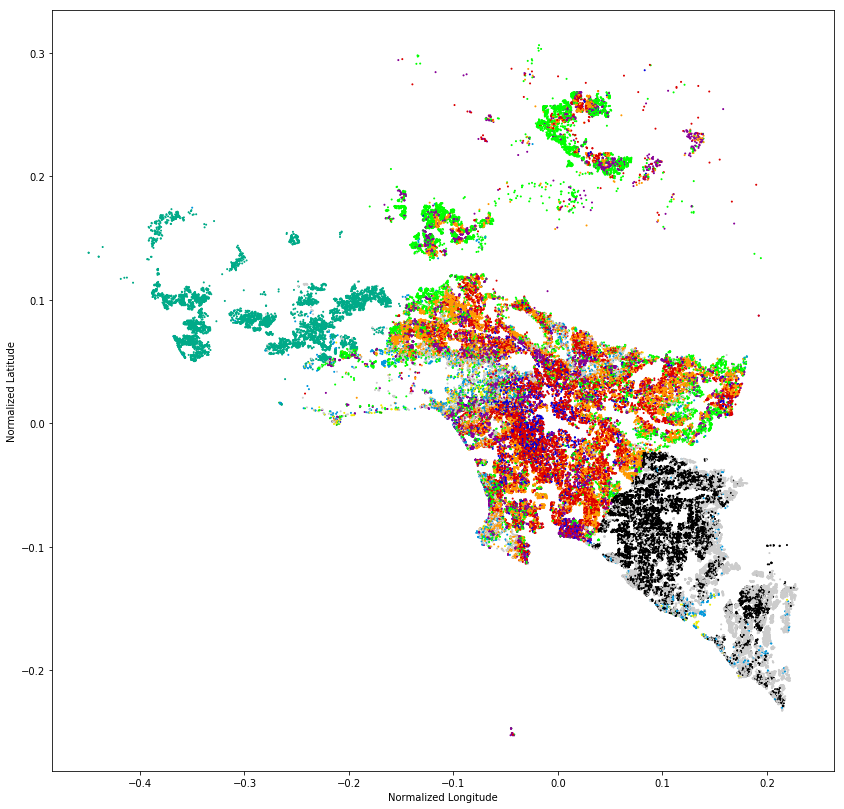

In [35]:
plt.figure(figsize=(14,14))
plt.xlabel("Normalized Longitude")
plt.ylabel("Normalized Latitude")
plt.scatter(prop_data_dist["longitude"], prop_data_dist["latitude"], s=1, c=[matplotlib.cm.spectral(float(i) /10) for i in kmeans.labels_])
plt.show()

For clustering we have used kMeans clustering algorithm. In this algorithm, we take a random set of k points on the plot and assume that they are the centers of the clusters.
 In this first pass the distance between the temporary cluster centers and all the points is taken.
Then, the cluster centers of the newly formed clusters are moved.
After which, in the next pass, we find the distance between all the points in and the cluster centers and move the cluster centers acordingly.
We keep on repeating the above steps till the time the cluster centers stop moving.

We prepared a dot-plot map for latitude vs longitude.This plot represents the actual physical distance between the parcels. We have normalized the values of Latitude and Longitude and have divided the points into 15 clusters. As expected the plot also clearly shows the shore line towards the left side of the plot. 
There are some cluster distributions which are a little skewed, that is because there are some clusters which has some empty spaces in between.


# 4. Merging External Dataset

## Datasets that can be merged: 
### Schools available:
This data can be useful for those people who have children who are school going age. If the house is near a school, then the residents have peace of mind knowing that the children are close by and can be accessed as and when needed. If the children are old enough to walk to school by themselves, then that saves a lot a transportation cost.
Closer proximity to schools increases the desirability of the school and hence the resale value. Since, generally, there is more police presence near schools, this leads to better safety around them.
Presence of a school nearby means that there would be a playground as well nearby. This factor attracts those people who might not have children but are interested in staying fit.
The above-mentioned factors increase the desirability of the property and hence the price also increases.
However, there are some disadvantages of living near schools as well. For example, increased traffic during school start and end times, noise from school events, parents parking their cars in the street causing traffic snarls which can be very annoying.<br>

**Final Verdict:** Living in an area near a school is like a double-edged sword. There are some factors which can jack up the price significantly but on the other side, there are some factors which could negatively affect the price. Final verdict varies from house to house, but we feel that the general trend is that having a school near your property is more advantageous from the standpoint of desirability.


### Recreational Facilities available:
Availability of recreational facilities nearby is desired by people of every age. It can be helpful in maintaining both mental and physical fitness. It has been found that living in a non-green area can cause issues like loneliness and depression. In such areas, rates of aggression and violence has also been found higher.
On the flip side, living near a recreational facility can have some problems like traffic snarls because of people trying to reach the facility especially on holidays and weekends, green areas attract wild animals like snakes which can be dangerous sometimes. <br>

**Final Verdict**: We think that availability of a recreational area near a property helps increase the property value because generally, people find such properties more desirable.<br>

<b>Effects of such data-set on the Zestimate:</b> The presence of these facilities near a property increases its value. In our case, if Zillow had not factoring them in, then this could cause an increase in the value of the logerror. Also, if a new school or a recreational facility opens up after the assessment by Zillow, then that could also lead to an increase in the logerror of that property.


### Integration of data: 
We plan to integrate this data into our model by measuring the distance between the co-ordinates of the properties and the recreational facility or school zone. The school zone is calculated by taking its co-ordinate upto 1 decimal place, this creates a circular zone of around 11 miles around the school, which then can be compared with the property’s co-ordinates.

In [5]:
rec = pd.read_csv('./data/RecAreas_CSV.csv')
rec = rec[np.isfinite(rec['RECAREALATITUDE'])]
rec = rec[np.isfinite(rec['RECAREALONGITUDE'])]

In [6]:
rec_zones = {}
s = set()
decimal_places = 2
# print(len(rec))
for row in rec.iterrows():

    dot_index = str(row[1][7]).index(".")
    long_str = str(row[1][7])[:dot_index+decimal_places]
    dot_index = str(row[1][6]).index(".")
    lat_str = str(row[1][6])[:dot_index+decimal_places]
    if (lat_str,long_str) in rec_zones:
       rec_zones[(lat_str,long_str)] += 1
    else:
       rec_zones[(lat_str,long_str)] = 1
#    s.add(lat_str+""+long_str)
#     print((row[1][7])," ",long_str)
#     print((row[1][6])," ",lat_str)

In [8]:
pub_schools = pd.read_csv('./data/pubschls.csv')

pub_schools = pub_schools[(pub_schools['County'] == 'Los Angeles') | (pub_schools['County'] == 'Orange') | (pub_schools['County'] == 'Ventura')]
pub_schools = pub_schools[pub_schools['StatusType'] != 'Closed']
pub_schools = pub_schools[np.isfinite(pub_schools['Latitude'])]
pub_schools = pub_schools[np.isfinite(pub_schools['Longitude'])]



pub_schools = pub_schools[pub_schools['SOC'].isin([60,62,66,65])]


In [9]:
zones = {}
decimal_places = 2
for row in pub_schools.iterrows():
   dot_index = str(row[1]['Longitude']).index(".")
   long_str = str(row[1]['Longitude'])[:dot_index+decimal_places]
   dot_index = str(row[1]['Latitude']).index(".")
   lat_str = str(row[1]['Latitude'])[:dot_index+decimal_places]
   if (lat_str,long_str) in zones:
       zones[(lat_str,long_str)] += 1
   else:
       zones[(lat_str,long_str)] = 1


In [163]:
data = pd.merge(prop_data,train_data,on='parcelid')

data = data[distance_cols + ['parcelid','logerror']]

In [11]:
prop_data = prop_data[np.isfinite(prop_data['latitude'])]
prop_data = prop_data[np.isfinite(prop_data['longitude'])]
decimal_places=2

num_schools = []

In [166]:
data = data[np.isfinite(data['latitude'])]
data = data[np.isfinite(data['longitude'])]
decimal_places=2

num_schools = []

In [12]:
num_schools = []
num_rec = []
for row in prop_data.iterrows():
    long = row[1]['longitude']/1000000
    lat =  row[1]['latitude']/1000000
    #     print(str(row[1]['longitude'])[:5])
    dot_index = str(long).index(".")
    long_str = str(long)[:dot_index+decimal_places]
    dot_index = str(lat).index(".")
    lat_str = str(lat)[:dot_index+decimal_places]
    if (lat_str,long_str) in zones:
        num_schools.append(zones[(lat_str,long_str)])
    else:
        num_schools.append(0)
    if (lat_str,long_str) in rec_zones:
        num_rec.append(rec_zones[(lat_str,long_str)])
    else:
        num_rec.append(0)


prop_data['num_schools'] = num_schools
prop_data['num_rec']  = num_rec

In [14]:
prop_data.to_csv('./data/unnormalized_prop_data.csv')

In [36]:
prop_data = pd.read_csv("./data/unnormalized_prop_data.csv", index_col=0)

In [4]:
prop_data = prop_data[distance_cols + ['parcelid', 'num_schools', 'num_rec']]

# 5. Building models

## Implementing Neural Network

In [7]:
train_data = pd.read_csv("./data/train_2017.csv", parse_dates=["transactiondate"])
prop = prop_data
sample = pd.read_csv('./data/sample_submission.csv')

df_train = train_data.merge(prop, how='left', on='parcelid')

df_train["transactiondate"] = pd.to_datetime(df_train["transactiondate"])
df_train["year"] = df_train["transactiondate"].dt.year
df_train["month"] = df_train["transactiondate"].dt.month

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = df_train["logerror"]

train_columns = x_train.columns
print train_columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

sample['parcelid'] = sample['ParcelId']
test_months = [k for k in sample.columns.values if k not in ["parcelid"]]

df_test = sample.merge(prop, on='parcelid', how='left')   
x_test = df_test[train_columns]

print('Shape of x_test:', x_test.shape)
print("Preparing x_test...")
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)


sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

len_x=int(x_train.shape[1])
print("len_x is:",len_x)


# Neural Network
print("\nSetting up neural network model...")
nn = Sequential()
nn.add(Dense(units = 350 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(units = 150 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(units = 50 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))

nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 70, verbose=0)

test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']
nn_pred = {}

for i in range(len(test_columns)):

    df_test["transactiondate"] = pd.to_datetime(test_dates[i])
    df_test["year"] = df_test["transactiondate"].dt.year
    df_test["month"] = df_test["transactiondate"].dt.month  
    x_test = df_test[train_columns]

    print('Shape of x_test:', x_test.shape)
    print("Preparing x_test...")
    for c in x_test.dtypes[x_test.dtypes == object].index.values:
        x_test[c] = (x_test[c] == True)

    x_test = sc.transform(x_test)
    #print("x_test.shape:",x_test.shape)
    y_pred_ann = nn.predict(x_test)

    nn_pred[test_columns[i]] = y_pred_ann.flatten()
    
    print( "Type of nn_pred is ", type(nn_pred[test_columns[i]]) )
    print( "Shape of nn_pred is ", nn_pred[test_columns[i]].shape )

    print( pd.DataFrame(nn_pred[test_columns[i]]).head() )

from datetime import datetime

for date in test_columns:
    sample[date] = nn_pred[date]

sample["ParcelId"] = sample["parcelid"]
sample.drop(["parcelid"], axis=1, inplace=True)

sample.to_csv('NN_submission.csv', index=False)


Index([u'actual_area', u'poolcnt', u'latitude', u'longitude', u'unitcnt',
       u'lotsizesquarefeet', u'bedroomcnt', u'calculatedbathnbr',
       u'hashottuborspa', u'fireplacecnt', u'taxvaluedollarcnt',
       u'buildingqualitytypeid', u'garagecarcnt', u'age', u'taxamount',
       u'airconditioningtypeid', u'regionidcounty', u'num_schools', u'num_rec',
       u'transactiondate_year', u'transactiondate_month',
       u'transactiondate_quarter'],
      dtype='object')
('Shape of x_test:', (2985217, 22))
Preparing x_test...
('len_x is:', 22)

Setting up neural network model...
('Shape of x_test:', (2985217, 22))
Preparing x_test...
('Type of nn_pred is ', <type 'numpy.ndarray'>)
('Shape of nn_pred is ', (2985217,))
          0
0  0.023364
1  0.024024
2  0.758637
3  0.046256
4  0.018200
('Shape of x_test:', (2985217, 22))
Preparing x_test...
('Type of nn_pred is ', <type 'numpy.ndarray'>)
('Shape of nn_pred is ', (2985217,))
          0
0  0.026145
1  0.026769
2  0.756431
3  0.048885
4  

***
## Description of MLP

<br><br>
- This model is based on the way a Human brain works.<br>
- It is basically an arrangement of small units called Neurons.<br>
- These neurons are connected with other neurons in the next layer.<br> 
- The neurons are activated on the basis of the input to the activation function.<br>

<img src="http://scikit-learn.org/stable/_images/multilayerperceptron_network.png" width="400" height="400" alt="Alt text that describes the graphic" title="Title text" />

Image source - "http://scikit-learn.org/stable/modules/neural_networks_supervised.html"

Each Layer has assigned weights to each incoming connection to the neurons in the layer and also each layer has a bias term. <br><br>

The Image represents a basic neural network.

The leftmost layer, known as the input layer, consists of a set of neurons \{x_i | x_1, x_2, ..., x_m\} representing the input features. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation w_1\*x_1 + w_2\*x_2 + ... + w_m*x_m, followed by a non-linear activation function like the hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.


There were a few surprises when using this model.<br>
One of them was that the model while training had random jumps in the Loss,
which was counter-intuitive, because as the training is done, the loss should decrease. Later, on reading about it. I realised that it because this SKlearn implementation uses Stocastic Gradient Descent by default, which make random jumps in gradients to converge faster and to avoid a local minima.

### Hyperparameters to tune the Model
1. Number of hidden layer and the size of each layer - a single hidden layer is enough to model a linear data.
    However, as the data becomes more complex, it can be modelled by using more number of hidden layer.
2. Solver and optimizer - There are multiple solvers used for weight optimization of the MLP, these include
    - ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
    - ‘sgd’ refers to stochastic gradient descent.
    - ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
3. Learning rate - A high learning rate means that the model is sensitive to outliers and variance. And a small learning rate means that the model is biased towards the data it observed previously. It is important to strike a balance here.
4. Activation Function - {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
    Activation function for the hidden layer.
    - ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
    - ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
    - ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
    - ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
5. alpha - L2 penalty (regularization term) parameter.

These are the major parameters to tune while training a MLP neural network.

### Features Selection

We will be using the following features:
- "transactiondate_year"
- "transactiondate_month"
- "transactiondate_quarter"
- "actual_area",
- "poolcnt",
- "latitude",
- "longitude",
- "unitcnt",
- "lotsizesquarefeet",
- "bedroomcnt",
- "calculatedbathnbr",
- "hashottuborspa",
- "fireplacecnt",
- "taxvaluedollarcnt",
- "buildingqualitytypeid",
- "garagecarcnt",
- "age",
- "taxamount",
- "airconditioningtypeid",
- "regionidcounty"

### Architecture

Our model uses 3 Densely connected Layers :
1st with 350 neurons
2nd with 150 neurons 
and 
3rd with 50 neurons

and the output layer is a dense layer with 1 neuron.

Each layer is followed by a Parametrized ReLU, for activation of neurons. 
Which in turn is followed by Dropout layer with a dropout rate of 50%.
Doing so prevents the network from overfitting.

### Evalution of the Model

Here we are evaluating the model by splitting the data into training and validation sets. We then fit the models on the training sets and then predict the values of the validation set. These prediction are checked for finding the MAE. 

NN on Validation Data:
MAE - 0.0690

NN on Testing Data:
MAE - 0.0648571

# 6. P-value

In [27]:
from sklearn.model_selection import train_test_split

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

len_x=int(x_train.shape[1])
print("len_x is:",len_x)


# Neural Network

In [51]:
print("\nSetting up neural network model...")


Setting up neural network model...


In [52]:
nn = Sequential()
nn.add(Dense(units = 350 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(units = 150 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(units = 50 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(Dropout(.5))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))

nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 70, verbose=0)

y_pred_ann = nn.predict(x_test)

In [53]:
import h5py
nn.save('./data/model.h5')

('Mean Absolute Error', 0.069603831822832168)
300


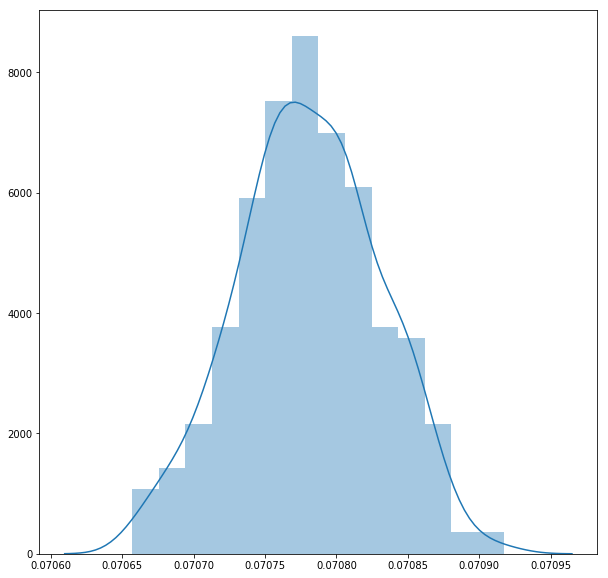

In [29]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error

# y_predict = (regr.predict(X_test))
y_predict = y_pred_ann.flatten()
mse = []
print("Mean Absolute Error",mean_absolute_error(y_test, y_predict))
for i in range(300):
    y_permutation = shuffle(y_test)
    mse.append(mean_absolute_error(y_permutation, y_predict))
print(len(mse))
plt.figure(figsize=(10,10))
sns.distplot(mse)
plt.show()

The P-value is 0.0033 for 300 substitutions
***

<img src="Best.png">

The above was our best submision. This submission used the above described neural network in the prediction. The result was relatively better than that of Linear Regression. (the screenshot has been committed in the repository with the name "Best.png".)

<img src="Second_best.png">

The above was our second best submision. This submission used Linear Regression that we developed in the first assignment.(the screenshot has been committed in the repository with the name "Second_best.png".)
***